In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Task-2:-  Video classification using CNN+LSTM model on UCF 101 dataset

Available classes in dataset: ['HorseRace', 'StillRings', 'ApplyLipstick', 'HammerThrow', 'VolleyballSpiking', 'Biking', 'PlayingCello', 'BodyWeightSquats', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'BoxingPunchingBag', 'BasketballDunk', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'Knitting', 'SumoWrestling', 'HorseRiding', 'Mixing', 'BrushingTeeth', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'IceDancing', 'CricketShot', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'PlayingFlute', 'SalsaSpin', 'CricketBowling', 'Typing', 'ApplyEyeMakeup', 'PlayingTabla', 'BalanceBeam', 'FloorGymnastics', 'HeadMassage', 'FrisbeeCatch', 'Rowing', 'Hammering', 'CuttingInKitchen', 'BenchPress', 'PushUps', 'Nunchucks', 'Archery', 'LongJump', 'BlowingCandles', 'WallPushups', 'PlayingViolin', 'PullUps', 'PlayingPiano', 'PlayingDhol', 'FrontCrawl', 'HulaHoop', 'CliffDiving', 'BandMarching', 'ParallelBars', 'RopeClimbing', 'YoYo', 'TrampolineJumping', 'JumpingJack', 'Drumming'

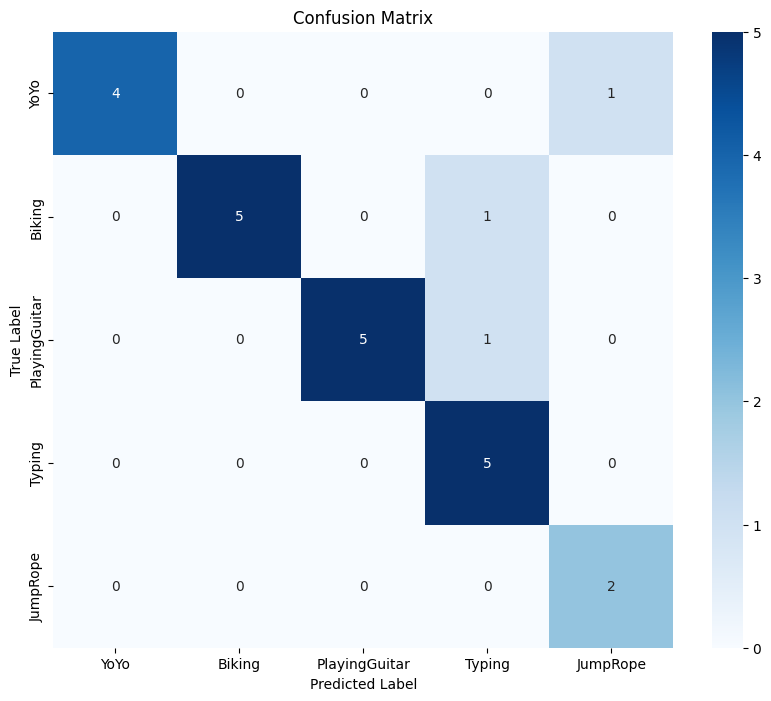


Classification Report:
               precision    recall  f1-score   support

         YoYo       1.00      0.80      0.89         5
       Biking       1.00      0.83      0.91         6
PlayingGuitar       1.00      0.83      0.91         6
       Typing       0.71      1.00      0.83         5
     JumpRope       0.67      1.00      0.80         2

     accuracy                           0.88        24
    macro avg       0.88      0.89      0.87        24
 weighted avg       0.91      0.88      0.88        24



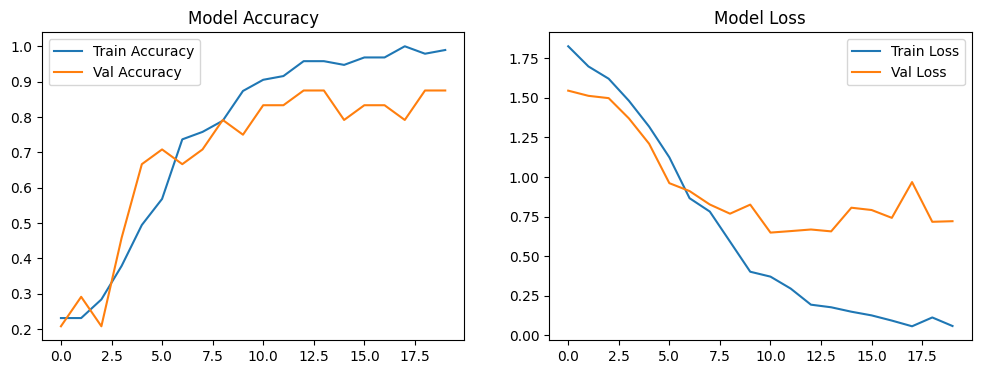


Performing inference on a sample test video:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: YoYo, Confidence: 0.9839


In [5]:
import os
import shutil
import random
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and parameters
SOURCE_DIR = '/kaggle/input/ucf101/UCF101/UCF-101'
DEST_DIR = '/kaggle/working/UCF101_subset'
SELECTED_CLASSES = ['YoYo', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10
IMG_SIZE = (112, 112)
FRAME_COUNT = 16
BATCH_SIZE = 8
EPOCHS = 20

# Step 1: Verify dataset and create subset
def verify_and_create_subset():
    if not os.path.exists(SOURCE_DIR):
        raise FileNotFoundError(f"Source directory {SOURCE_DIR} does not exist.")
    
    available_classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
    print("Available classes in dataset:", available_classes)
    
    missing_classes = [cls for cls in SELECTED_CLASSES if cls not in available_classes]
    if missing_classes:
        print(f"Warning: The following classes were not found: {missing_classes}")
    
    os.makedirs(DEST_DIR, exist_ok=True)
    used_classes = [cls for cls in SELECTED_CLASSES if cls in available_classes]
    
    if not used_classes:
        raise ValueError("No selected classes found in the dataset.")
    
    for cls in used_classes:
        class_path = os.path.join(SOURCE_DIR, cls)
        dest_class_path = os.path.join(DEST_DIR, cls)
        os.makedirs(dest_class_path, exist_ok=True)
        videos = [v for v in os.listdir(class_path) if v.endswith('.avi')]
        if len(videos) < VIDEOS_PER_CLASS:
            print(f"Warning: Only {len(videos)} videos found for class {cls}.")
        selected = random.sample(videos, min(VIDEOS_PER_CLASS, len(videos)))
        for video in selected:
            shutil.copy(os.path.join(class_path, video), dest_class_path)
    
    return used_classes

# Step 2: Extract frames from videos
def extract_frames(video_path, frame_count=FRAME_COUNT, img_size=IMG_SIZE):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames-1, frame_count, dtype=int)
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, img_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    cap.release()
    while len(frames) < frame_count:
        frames.append(frames[-1] if frames else np.zeros((*img_size, 3), dtype=np.uint8))
    
    return np.array(frames)

# Step 3: Load and preprocess dataset
def load_dataset(used_classes):
    X, y = [], []
    for cls in used_classes:
        class_path = os.path.join(DEST_DIR, cls)
        for video in os.listdir(class_path):
            if video.endswith('.avi'):
                video_path = os.path.join(class_path, video)
                frames = extract_frames(video_path)
                X.append(frames)
                y.append(cls)
    
    if not X:
        raise ValueError("No videos were loaded.")
    
    X = np.array(X) / 255.0
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y = to_categorical(y_encoded)
    return X, y, le, y_encoded

# Step 4: Build CNN+LSTM model
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        TimeDistributed(Conv2D(32, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 5: Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Step 6: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.show()

# Step 7: Inference on a single video
def predict_video(video_path, model, le, frame_count=FRAME_COUNT, img_size=IMG_SIZE):
    frames = extract_frames(video_path, frame_count, img_size)
    frames = np.array([frames]) / 255.0
    prediction = model.predict(frames)
    predicted_class = le.inverse_transform([np.argmax(prediction, axis=1)[0]])[0]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Main execution
if __name__ == '__main__':
    try:
        # Verify dataset and create subset
        used_classes = verify_and_create_subset()
        
        # Load and preprocess data
        X, y, le, y_encoded = load_dataset(used_classes)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Build and train model
        input_shape = (FRAME_COUNT, *IMG_SIZE, 3)
        model = build_model(input_shape, len(used_classes))
        history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_test, y_test), verbose=1)
        
        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Generate predictions
        y_pred = model.predict(X_test)
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, used_classes)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1),
                                  target_names=used_classes, zero_division=0))
        
        # Plot training history
        plot_training_history(history)
        
        # Example inference on a test video
        print("\nPerforming inference on a sample test video:")
        test_video_path = os.path.join(DEST_DIR, used_classes[0], os.listdir(os.path.join(DEST_DIR, used_classes[0]))[0])
        predicted_class, confidence = predict_video(test_video_path, model, le)
        print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")